# Assessing the precision of the Karhunen-Loeve method

We will work in the case of a one-dimensional process, but the results should be scalable to higher-dimensional processes.

In [1]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.signal import find_peaks
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
#let's create a grid and define a covariance model
# We choose the matern model as it is frequently used to model stochastic fields
grid = ot.RegularGrid(0,1,100)
covaModel10_ = ot.MaternModel([10.], [1.],0.5)
process = ot.GaussianProcess(covaModel10_, grid)

In this notebook we will not explore all the existing covariance models, only the Matern model which is widely used.
We will look at the effect of the different parameters controlling this model, as well as their effect on a subsequent Karhunen Loeve decomposition.
The three parameters controlling the Matern Model are the amplitude, scale and nu parameter.
The amplitude controlls the amplitude of the stochastic process:

In [3]:
amplitudes = [1,5,10,20,50]
samples = []
for amp in amplitudes:
    cova_model = ot.MaternModel([10.], [float(amp)],0.5)
    process = ot.GaussianProcess(cova_model, grid)
    procSample = process.getSample(5000)
    array = np.array(ot.Sample([procSample.getField(i).getValues().asPoint() for i in range(procSample.getSize())]))
    mean = array.mean(axis=1).mean()
    std = array.std(axis=1).mean()
    samples.append(procSample)
    print('Mean: {}, StandDev: {} '.format(round(mean,4),str(round(std,4))))

Mean: 0.0056, StandDev: 0.8883 
Mean: -0.0049, StandDev: 4.4411 
Mean: 0.0451, StandDev: 8.8802 
Mean: -0.0364, StandDev: 17.774 
Mean: 0.2052, StandDev: 44.3985 


We correctly retrieve a value near to the value of the amplitude of the Matern Model, by calculating the intrinsic standard deviation in each field and taking the global mean.

Now let's check the influence of the scale and nu parameter on the mean and standard deviation of a process with fixed amplitude.

In [4]:
amp = [10]
scales = [1,10,20,50,75]
nus = [0.2,0.4,1,3,5,10,20]
samples_2 = []
for i in range(10):
    scale = np.random.choice(scales)
    nu = np.random.choice(nus)
    cova_model = ot.MaternModel([scale], amp,nu)
    process = ot.GaussianProcess(cova_model, grid)
    procSample = process.getSample(10000)
    array = np.array(ot.Sample([procSample.getField(i).getValues().asPoint() for i in range(procSample.getSize())]))
    mean = array.mean(axis=1).mean()
    std = array.std(axis=1).mean()
    samples.append(procSample)
    print('For nu:{} , scale:{}'.format(nu,scale))
    print('    Mean: {}, StandDev: {} '.format(round(mean,4),str(round(std,4))))

For nu:5.0 , scale:1
    Mean: 0.0284, StandDev: 9.8511 
For nu:10.0 , scale:10
    Mean: 0.0216, StandDev: 8.3968 
For nu:10.0 , scale:1
    Mean: 0.0113, StandDev: 9.8283 
For nu:3.0 , scale:20
    Mean: -0.0404, StandDev: 7.1627 
For nu:20.0 , scale:75
    Mean: -0.0892, StandDev: 3.058 
For nu:20.0 , scale:75
    Mean: -0.036, StandDev: 3.0374 
For nu:5.0 , scale:75
    Mean: 0.0904, StandDev: 3.2316 
For nu:1.0 , scale:50
    Mean: 0.0361, StandDev: 5.38 
For nu:3.0 , scale:1
    Mean: -0.024, StandDev: 9.8349 
For nu:0.2 , scale:20
    Mean: -0.0513, StandDev: 8.5813 


We can observe variation in the values of the standard deviation. This means there is interaction between the scale, the amplitude and the nu parameter, on the scope of values the field takes. 
Let's plot the variation of the standard deviation in regard to the scale. Values normalized of course.

In [5]:
def getMeanPeakValue(array):
    peaks = []
    for rea in array : 
        argPeak = find_peaks(rea, prominence = [0.3, None])
        n_peaks = len(argPeak[0])
        peaks.append(n_peaks)
    peaks = np.array(peaks)
    mean_peak_val = peaks.mean()
    return mean_peak_val

amp = [10]
nus = [0.2,0.5,0.8,1,1.15,1.5,3,6,8,12,15,30,50]
scales = [0.5,1,5,10,20,25,50,75,100,150,200,300]
thresholds = [0.66,0.33,0.1,1e-3,1e-5]
scaleNormed = np.array(scales)/100 # for plotting
scale_nu_stds = np.zeros([len(nus),len(scales)]) # intra standard deviation
mean_peak_vals = np.zeros([len(nus),len(scales)])

#For the Karhunen Loeve Expansion
KL_thresh_scale_nu_stds = np.zeros([len(thresholds),len(nus),len(scales)])
KL_thresh_mean_peak_vals = np.zeros([len(thresholds),len(nus),len(scales)])
KL_size_expansion = np.zeros([len(thresholds),len(nus),len(scales)])

for p, nu in enumerate(nus) :
    stds_nu = []
    mean_peaks = []

    stds_nu_kl = []
    mean_peaks_kl = []
    
    for s, scale in enumerate(scales):
        cova_model = ot.MaternModel([scale], amp,nu)
        process = ot.GaussianProcess(cova_model, grid)
        for t, thresh in enumerate(thresholds) :
            kl_expansion = ot.KarhunenLoeveP1Algorithm(grid, cova_model, thresh)
            kl_expansion.run()
            kl_result = kl_expansion.getResult()
            kl_lifting = ot.KarhunenLoeveLifting(kl_result)
            size_kl = kl_result.getEigenValues().getSize()
            kl_processSample = kl_lifting(ot.Sample(np.random.normal(size=(5000,size_kl))))
            kl_array = np.array(ot.Sample([kl_processSample.getField(i).getValues().asPoint() for i in range(kl_processSample.getSize())]))
            mean_peak_val_kl = getMeanPeakValue(kl_array)
            std_intra_kl = kl_array.std(axis=1).mean()
            KL_thresh_scale_nu_stds[t,p,s] = std_intra_kl
            KL_thresh_mean_peak_vals[t,p,s] = mean_peak_val_kl      
            KL_size_expansion[t,p,s] = size_kl
        procSample = process.getSample(5000)
        array = np.array(ot.Sample([procSample.getField(i).getValues().asPoint() for i in range(procSample.getSize())]))
        mean_peak_val = getMeanPeakValue(array)
        mean_peaks.append(mean_peak_val)
        std_intra = array.std(axis=1).mean()
        stds_nu.append(std_intra)
    stds_nu = np.array(stds_nu)
    stds_nuNormed = stds_nu/10
    scale_nu_stds[p, ...] = stds_nuNormed
    mean_peak_vals[p, ...] = mean_peaks


Text(0.5, 1.0, 'Evolution of the standard deviation - amplitude coefficient with respect to the scale - mesh length coefficient, intra-realization')

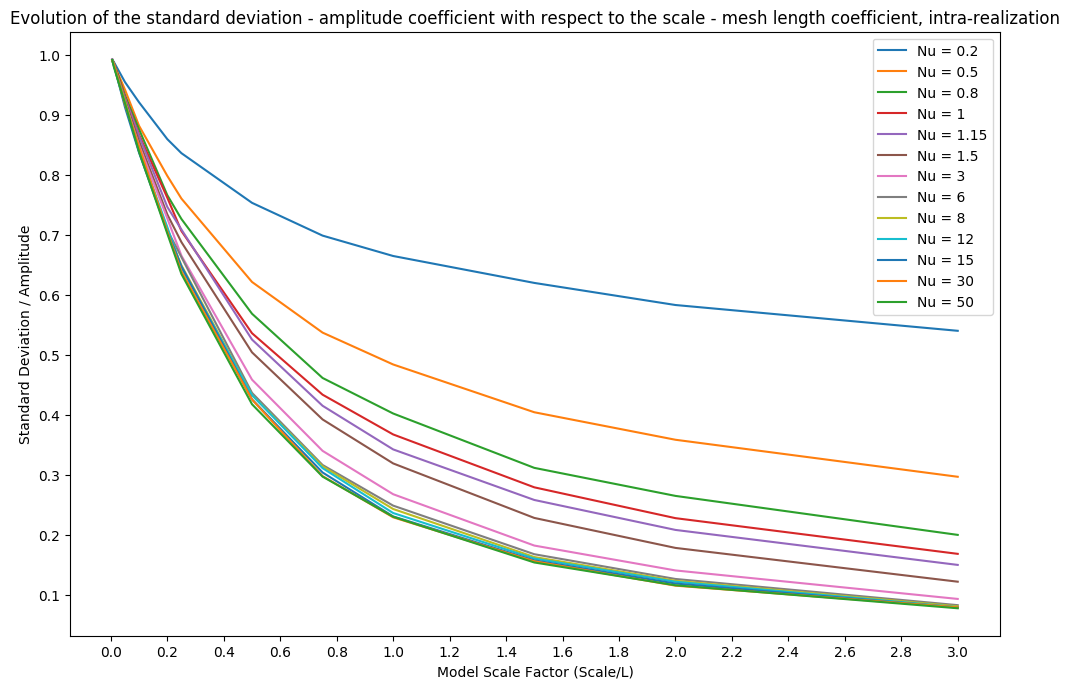

In [6]:
fig, ax= plt.subplots(figsize=(12,8), dpi= 100)
for i in range(scale_nu_stds.shape[0]):
    line = ax.plot(scaleNormed, scale_nu_stds[i],label='Nu = {}'.format(str(nus[i])))
leg=plt.legend()
xl=ax.set_xlabel("Model Scale Factor (Scale/L)")
yl=ax.set_ylabel("Standard Deviation / Amplitude")
ax.locator_params(axis='x', nbins=30)
ax.locator_params(axis='y', nbins=20)
ax.set_title(label='Evolution of the standard deviation - amplitude coefficient with respect to the scale - mesh length coefficient, intra-realization')


Text(0.5, 1.0, 'Evolution of the standard deviation - amplitude coefficient with respect to the scale - mesh length coefficient \nwhen using the Karhunen-Loeve expansion')

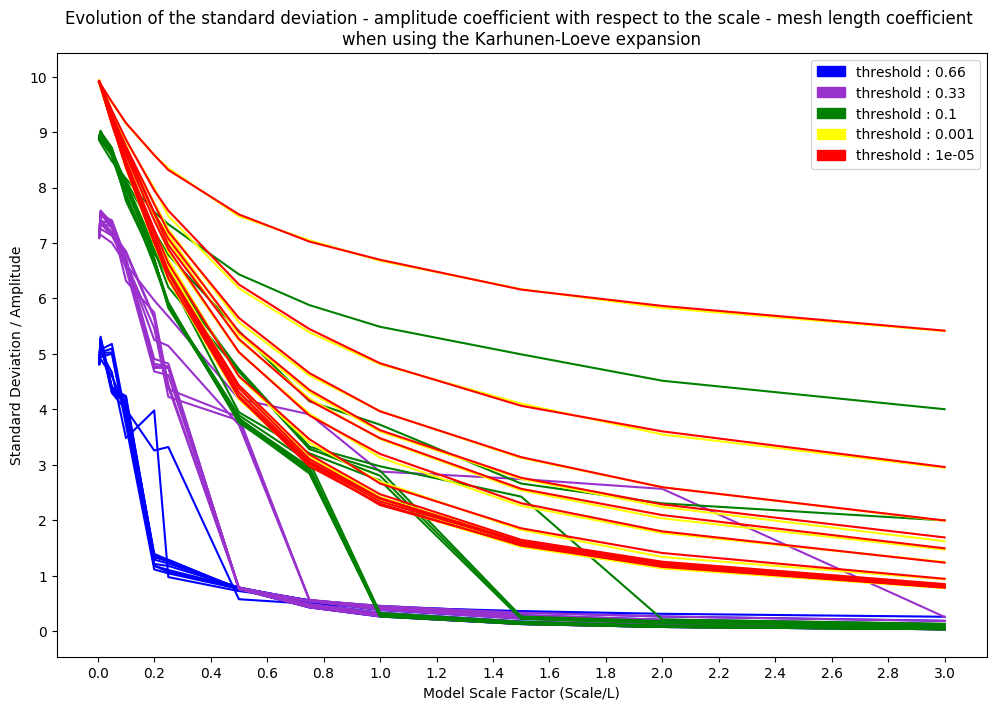

In [7]:



col = ['blue','darkorchid','green','yellow','red']
patches = [Patch(color = col[i], label = 'threshold : '+str(thresholds[i])) for i in range(len(col))]

fig, ax= plt.subplots(figsize=(12,8), dpi= 100)
for i in range(KL_thresh_scale_nu_stds.shape[0]):
    for j in range(KL_thresh_scale_nu_stds.shape[1]):
        line = ax.plot(scaleNormed, KL_thresh_scale_nu_stds[i,j],color = col[i])
leg=plt.legend(handles=patches)
xl=ax.set_xlabel("Model Scale Factor (Scale/L)")
yl=ax.set_ylabel("Standard Deviation / Amplitude")
ax.locator_params(axis='x', nbins=30)
ax.locator_params(axis='y', nbins=20)
ax.set_title(label='Evolution of the standard deviation - amplitude coefficient with respect to the scale - mesh length coefficient \nwhen using the Karhunen-Loeve expansion')


Now that we have seen the effect of the scale and nu parameter on the effective standard deviation of the stochastic process, we should introduce an other parameter for measuring the process. 

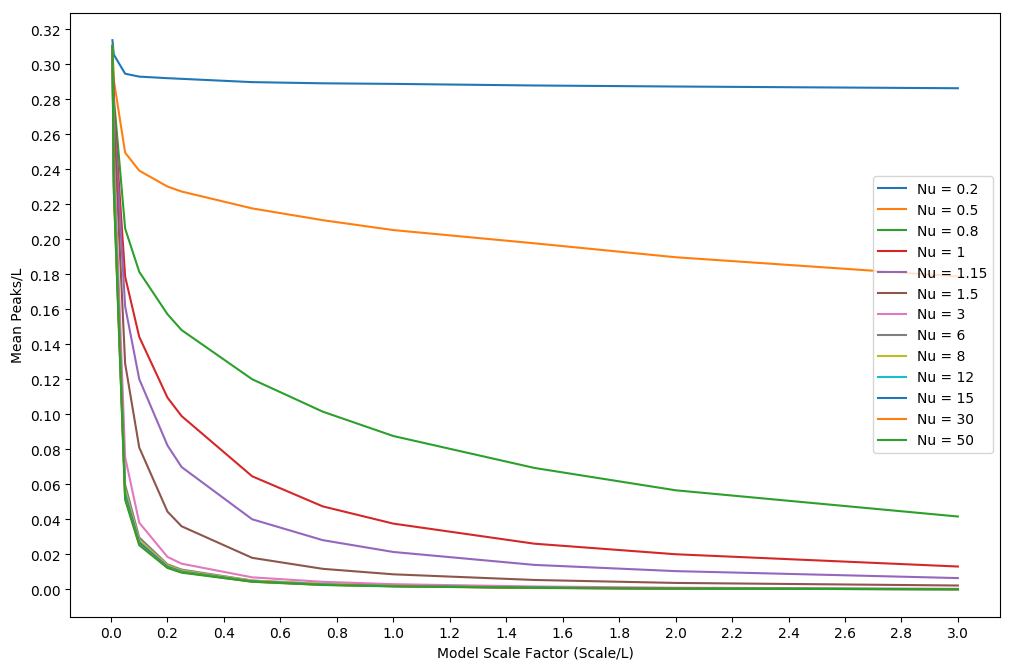

In [8]:
fig, ax= plt.subplots(figsize=(12,8), dpi= 100)
for i in range(scale_nu_stds.shape[0]):
    line = ax.plot(scaleNormed, mean_peak_vals[i]/100,label='Nu = {}'.format(str(nus[i])))
leg=plt.legend()
xl=ax.set_xlabel("Model Scale Factor (Scale/L)")
yl=ax.set_ylabel("Mean Peaks/L")
ax.locator_params(axis='x', nbins=30)
ax.locator_params(axis='y', nbins=18)

Text(0.5, 1.0, 'Variation of the mean peak value with respect to the threshold of the Karhunen-Loeve decomposition')

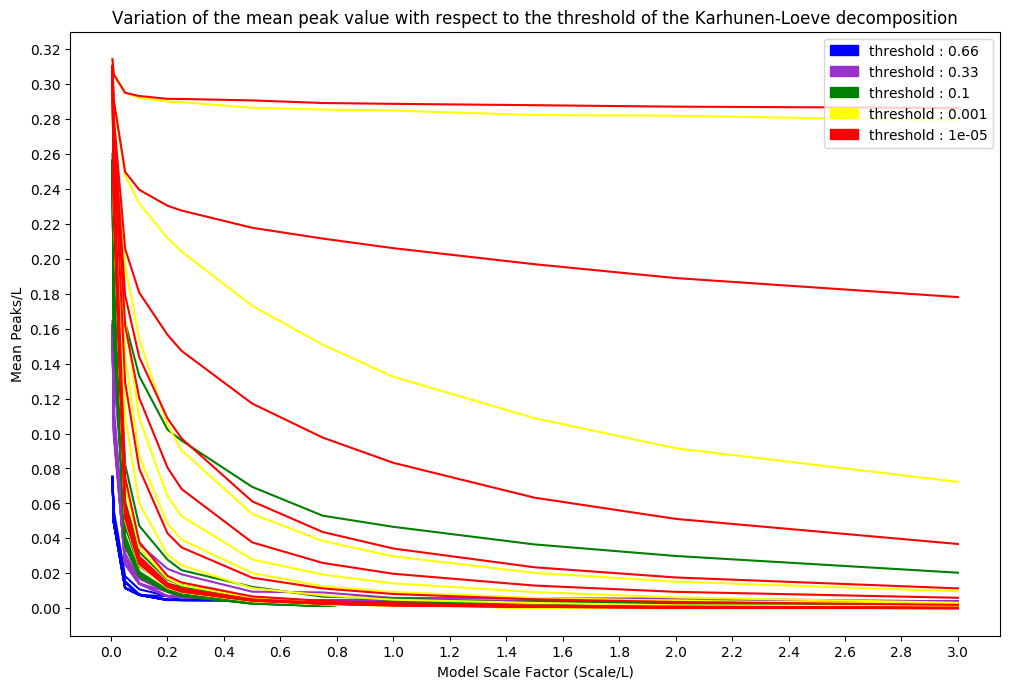

In [9]:
col = ['blue','darkorchid','green','yellow','red']
patches = [Patch(color = col[i], label = 'threshold : '+str(thresholds[i])) for i in range(len(col))]

fig, ax= plt.subplots(figsize=(12,8), dpi= 100)
for i in range(KL_thresh_mean_peak_vals.shape[0]):
    for j in range(KL_thresh_mean_peak_vals.shape[1]):
        line = ax.plot(scaleNormed, KL_thresh_mean_peak_vals[i,j]/100,color = col[i],label = thresholds[i])
leg=plt.legend(handles = patches,loc='upper right')
xl=ax.set_xlabel("Model Scale Factor (Scale/L)")
yl=ax.set_ylabel("Mean Peaks/L")
ax.locator_params(axis='x', nbins=30)
ax.locator_params(axis='y', nbins=18)
ax.set_title(label='Variation of the mean peak value with respect to the threshold of the Karhunen-Loeve decomposition')


Text(0.5, 1.0, 'Variation of the number of mode with respect to the threshold of the Karhunen-Loeve decomposition')

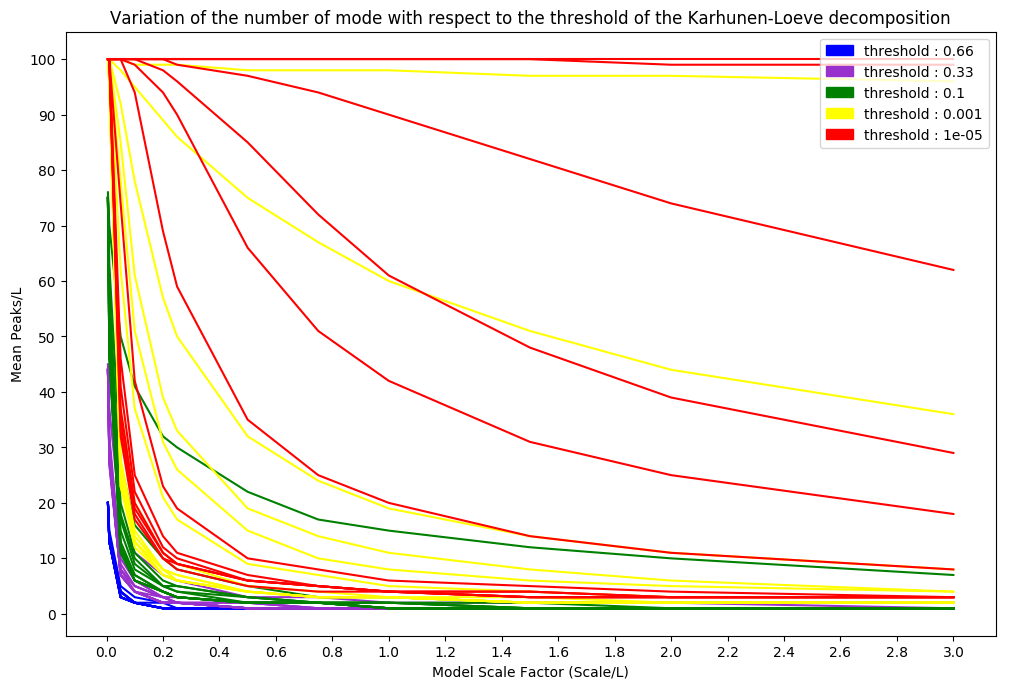

In [12]:
col = ['blue','darkorchid','green','yellow','red']
patches = [Patch(color = col[i], label = 'threshold : '+str(thresholds[i])) for i in range(len(col))]

fig, ax= plt.subplots(figsize=(12,8), dpi= 100)
for i in range(KL_size_expansion.shape[0]):
    for j in range(KL_size_expansion.shape[1]):
        line = ax.plot(scaleNormed, KL_size_expansion[i,j],color = col[i],label = thresholds[i])
leg=plt.legend(handles = patches,loc='upper right')
xl=ax.set_xlabel("Model Scale Factor (Scale/L)")
yl=ax.set_ylabel("Mean Peaks/L")
ax.locator_params(axis='x', nbins=30)
ax.locator_params(axis='y', nbins=18)
ax.set_title(label='Variation of the number of mode with respect to the threshold of the Karhunen-Loeve decomposition')
